# Motion planning by learning the solution manifold in trajectory optimization
by Takayuki Osa
#### Environment Setup

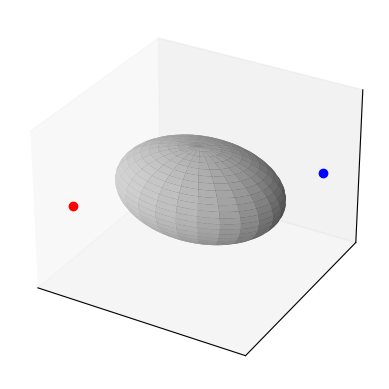

In [129]:
# from mpl_toolkits.mplot3d import Axes3D  # Not needed with Matplotlib 3.6.3
import matplotlib.pyplot as plt
import numpy as np
# import random

# random.seed(42)

fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

coefs = (1, 2, 2)  # Coefficients in a0/c x**2 + a1/c y**2 + a2/c z**2 = 1 
# Radii corresponding to the coefficients:
rx, ry, rz = 1/np.sqrt(coefs)

# Set of all spherical angles
u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

# Cartesian coordinates that correspond to the spherical angles:
# (this is the equation of an ellipsoid):
x = rx * np.outer(np.cos(u), np.sin(v))
y = ry * np.outer(np.sin(u), np.sin(v))
z = rz * np.outer(np.ones_like(u), np.cos(v))

q0 = [1, 1, 0]
plt.plot(q0[0], q0[1], q0[2], 'bo')
q1 = [-1, -1, 0]
plt.plot(q1[0], q1[1], q1[2], 'ro')

# Plot
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='lightgray')

# Hide grid lines
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])


# Background color
# ax.set_facecolor('white')
# ax.w_xaxis.set_pane_color('lightgray')
# ax.w_yaxis.set_pane_color('lightgray')
# ax.w_zaxis.set_pane_color('lightgray')

# Adjustment of the axes, so that they all have the same span
max_radius = max(rx, ry, rz)
for axis in 'xyz':
    getattr(ax, 'set_{}lim'.format(axis))((-max_radius*1.25, max_radius*1.25))

plt.show()


#### Hyperparamters

In [133]:
alpha = 10

#### Problem Formulation

In [130]:
def argmax(r):
    return r[np.argmax(r)]


def shaping_func(r):
    r_max = np.max(r)
    r_med = np.median(r)
    return np.exp(alpha*(r - r_max))/(r_max - r_med) if (r >= r_med).any() else 0

def shaping_func_lsmo(r):
    return np.exp(alpha*(r))

#### Functions
The paper plots four (4) non-convex equations. The figure plots the range x<sub>1</sub> &in; [0, 2] and x<sub>2</sub> &in; [0, 2].

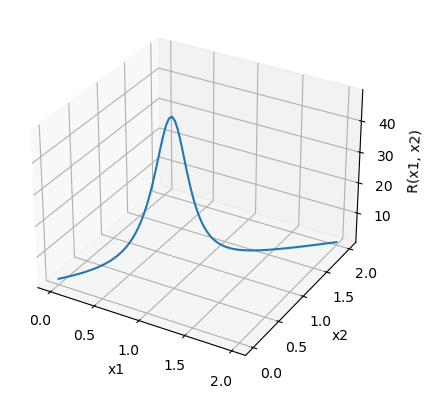

In [131]:
fig = plt.figure(figsize=plt.figaspect(1))  # Square figure
ax = fig.add_subplot(111, projection='3d')

x1 = np.linspace(0, 2, 100)
x2 = np.linspace(0, 2, 100)

def d(eq):
    return np.exp(-2*eq)

def r1(x1, x2):
    if np.less(x1, 0.5).any():
        return d(((x2 - 1.05)**2 + (x1 - 0.5)**2)**0.5)        
    elif np.greater_equal(x1, 1.5).any():
        return d(((x2 - 0.75)**2 + (x1 - 1.5)**2)**0.5)
    else:
        return d(abs(-0.3*x1 - x2 + 1.2) / 1.09**2)

def r2(x1, x2):
    return d(abs((x2 - 1.05)**2 + (x1 + 1)**2 - 2.5))

# print (np.greater_equal(x1, 1.4))

def r3(x1, x2):
    if np.less(x1, 0.7).any():
        return d(((x2 - 0.94)**2 + (x1 - 0.7)**2)**0.5 + 0.2*x2 + 0.14)
    elif np.greater_equal(x1, 1.4).any():
        return d(((x2 - 1.08)**2 + (x1 - 1.4)**2)**0.5 + 0.2*x2 + 0.14)
    else:
        return d((abs(0.2*x1 - x2 + 0.8)/1.04**2) + 0.2*x2 + 0.14)

def r4(x1, x2):
    return d(abs((x2 - 1)**2 + (x1 - 1)**2 - 0.5))

ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('R(x1, x2)')

# ax.plot_surface(x1, x2, r1(x1, x2))
# plt.plot(x1, x2, shaping_func_lsmo(r1(x1, x2)))
# plt.plot(x1, x2, shaping_func_lsmo(r2(x1, x2)))
plt.plot(x1, x2, shaping_func_lsmo(r3(x1, x2)))
# plt.plot(x1, x2, shaping_func_lsmo(r4(x1, x2)))

# # Uncommnet for top view
# ax.elev = 90
# ax.azim = 90

# plt.show()

### Proposal Distribution
##### Markov chain Monte Carlo (MCMC)
This code is from this article: https://exowanderer.medium.com/metropolis-hastings-mcmc-from-scratch-in-python-c21e53c485b7

(array([5.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 2.000e+01, 2.600e+01,
        2.600e+01, 4.800e+01, 7.700e+01, 1.050e+02, 1.550e+02, 2.210e+02,
        3.200e+02, 4.600e+02, 5.460e+02, 6.840e+02, 8.820e+02, 9.970e+02,
        1.077e+03, 1.276e+03, 1.244e+03, 1.391e+03, 1.376e+03, 1.297e+03,
        1.205e+03, 1.171e+03, 1.079e+03, 9.330e+02, 7.950e+02, 6.750e+02,
        5.200e+02, 3.680e+02, 2.910e+02, 2.530e+02, 1.910e+02, 1.190e+02,
        5.200e+01, 3.700e+01, 3.300e+01, 1.900e+01, 6.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 6.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 1.000e+00]),
 array([-3.74583605, -3.57637277, -3.4069095 , -3.23744622, -3.06798294,
        -2.89851966, -2.72905639, -2.55959311, -2.39012983, -2.22066656,
        -2.05120328, -1.88174   , -1.71227672, -1.54281345, -1.37335017,
        -1.20388689, -1.03442362, -0.86496034, -0.69549706, -0.52603378,
        -0.35657051, -0.18710723, -0.01764395,  0.15181933,  0.3212826 ,
         0.

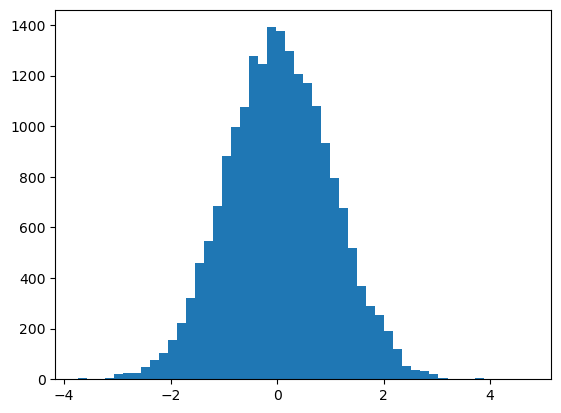

In [166]:
def mcmc_updater(curr_state, curr_likeli, 
      likelihood, proposal_distribution):
    """ Propose a new state and compare the likelihoods
    
    Given the current state (initially random), 
      current likelihood, the likelihood function, and 
      the transition (proposal) distribution, `mcmc_updater` generates 
      a new proposal, evaluate its likelihood, compares that to the current 
      likelihood with a uniformly samples threshold, 
    then it returns new or current state in the MCMC chain.

    Args:
        curr_state (float): the current parameter/state value
        curr_likeli (float): the current likelihood estimate
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state

    Returns:
        (tuple): either the current state or the new state
          and its corresponding likelihood
    """
    # Generate a proposal state using the proposal distribution
    # Proposal state == new guess state to be compared to current
    proposal_state = proposal_distribution(curr_state)

    # Calculate the acceptance criterion
    prop_likeli = likelihood(proposal_state)
    accept_crit = prop_likeli / curr_likeli

    # Generate a random number between 0 and 1
    accept_threshold = np.random.uniform(0, 1)

    # If the acceptance criterion is greater than the random number,
    # accept the proposal state as the current state
    if accept_crit > accept_threshold:
        return proposal_state, prop_likeli

    # Else
    return curr_state, curr_likeli

def metropolis_hastings(
        likelihood, proposal_distribution, initial_state, 
        num_samples, stepsize=0.5, burnin=0.2):
    """ Compute the Markov Chain Monte Carlo

    Args:
        likelihood (function): a function handle to compute the likelihood
        proposal_distribution (function): a function handle to compute the 
          next proposal state
        initial_state (list): The initial conditions to start the chain
        num_samples (integer): The number of samples to compte, 
          or length of the chain
        burnin (float): a float value from 0 to 1.
          The percentage of chain considered to be the burnin length

    Returns:
        samples (list): The Markov Chain,
          samples from the posterior distribution
    """
    samples = []

    # The number of samples in the burn in phase
    idx_burnin = int(burnin * num_samples)

    # Set the current state to the initial state
    curr_state = initial_state
    curr_likeli = likelihood(curr_state)

    for i in range(num_samples):
        # The proposal distribution sampling and comparison
        #   occur within the mcmc_updater routine
        curr_state, curr_likeli = mcmc_updater(
            curr_state=curr_state,
            curr_likeli=curr_likeli,
            likelihood=likelihood,
            proposal_distribution=proposal_distribution
        )

        # Append the current state to the list of samples
        if i >= idx_burnin:
            # Only append after the burnin to avoid including
            #   parts of the chain that are prior-dominated
            samples.append(curr_state)

    return samples

def likelihood(x):
    # Standard Normal Distribution
    # An underlying assumption of linear regression is that the residuals
    # are Gaussian Normal Distributed; often, Standard Normal distributed
    return np.exp(-x**2 / 2) / np.sqrt(2 * np.pi)

def proposal_distribution(x, stepsize=0.5):
    # Select the proposed state (new guess) from a Gaussian distribution
    #  centered at the current state, within a Guassian of width `stepsize`
    return np.random.normal(x, stepsize)

np.random.seed(42)

initial_state = 0  # Trivial case, starting at the mode of the likelihood
num_samples = int(2.5e4)
burnin = 0.2

samples = metropolis_hastings(
    likelihood,
    proposal_distribution,
    initial_state,
    num_samples,
    burnin=burnin
) # Outputs a list of 8000 samples from proposal distribution

# fig, axs = plt.subplots(1, 2, sharey=False, tight_layout=True)

x1 = [x for x in range(20000)]
# print(len(x1), len(samples))
# plt.plot(x1, samples)
plt.hist(samples,  bins=50)

#### Algorithm 1. Abstract of Learning the Solution Manifold in Optimization (LSMO)
Input:  Objective function R(x), proposal distribution p<sup>prop</sup>(x), shaping function f\
Output: x*

##### Traning phase
1. Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)
2. Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N
3. Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)
##### Generation phase
4. Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z
5. (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

Return: x<sup>*</sup>

##### Step 1: Generate N synthetic samples {x<sub>i</sub>}<sup>N</sup><sub>i=1</sub> from the proposal distribution p<sup>prop</sup>(x)

[-0.047739135372408925, -0.047739135372408925, -0.047739135372408925, -0.4579033659386426, -0.4579033659386426, -0.3168852607075323, 0.5646045655611672, 0.3107461809863103, 1.152403468950075, 1.3487876504756373] 

x1:  [-0.047739135372408925, -0.047739135372408925, -0.047739135372408925, -0.4579033659386426, -0.4579033659386426, -0.3168852607075323, 0.5646045655611672, 0.3107461809863103, 1.152403468950075, 1.3487876504756373] 
x2:  [-1.5011277310435027, -1.5011277310435027, -1.180066836609794, -1.1769412498178895, -1.1769412498178895, -1.1769412498178895, -0.7078008005880358, -0.3401203872670226, 0.042393210310236074, 0.38781399523890364]


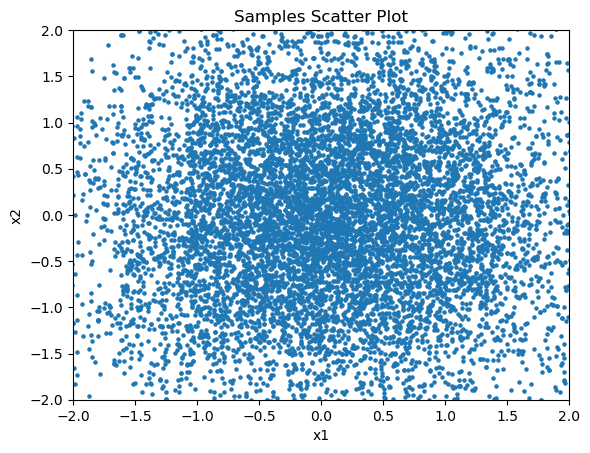

In [167]:
print(samples[0:10], "\n")
# sample_x1 = [samples[i] for i in range(0, len(x1), 2)]
# sample_x2 = [samples[i] for i in range(1, len(x1), 2)]
sample_x1 =samples[0:10000]
sample_x2 =samples[10000:]

print("x1: ", sample_x1[0:10], "\nx2: ", sample_x2[0:10])

plt.scatter(sample_x1,sample_x2, s=5)
plt.title('Samples Scatter Plot')
plt.xlabel('x1')
plt.ylabel('x2')

plt.xlim(-2,2)
plt.ylim(-2,2)

# Show the plot
plt.show()

##### Step 2: Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,N

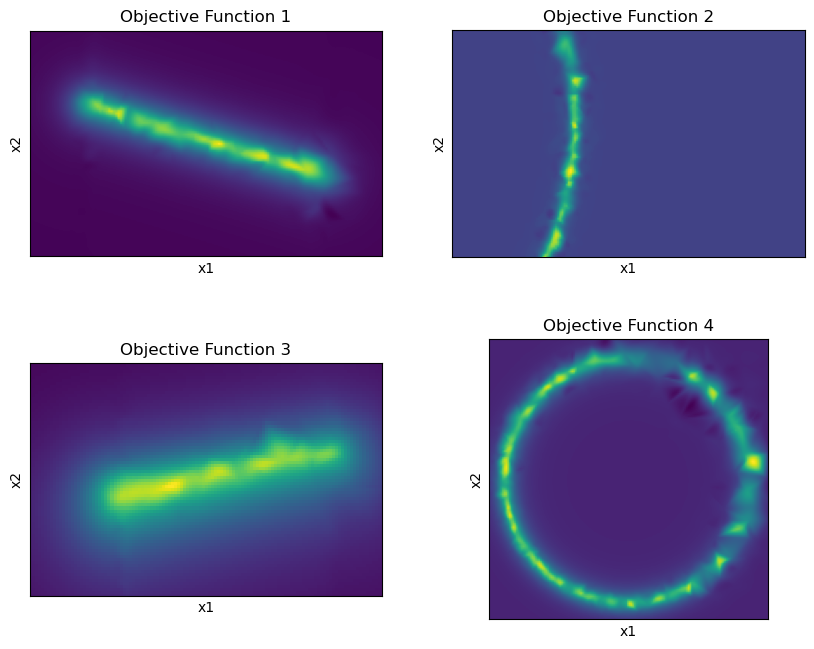

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

f1, f2, f3, f4 = [], [], [], []

x = sample_x1  # X values
y = sample_x2  # Y values

for i in range(len(sample_x1)):
    r1_out = r1(sample_x1[i],sample_x2[i])
    f1.append(shaping_func_lsmo(r1_out))
     
    r2_out = r2(sample_x1[i],sample_x2[i])
    f2.append(shaping_func_lsmo(r2_out))
 
    r3_out = r3(sample_x1[i],sample_x2[i])
    f3.append(shaping_func_lsmo(r3_out))
     
    r4_out = r4(sample_x1[i],sample_x2[i])
    f4.append(shaping_func_lsmo(r4_out))

intensity1, intensity2, intensity3, intensity4 = f1, f2, f3, f4  # Intensity values

# Define grid
grid_x, grid_y = np.mgrid[0:10:1000j, 0:10:1000j]

# Interpolate the intensity values on the grid
grid_z1 = griddata((x, y), intensity1, (grid_x, grid_y), method='cubic')
grid_z2 = griddata((x, y), intensity2, (grid_x, grid_y), method='cubic')
grid_z3 = griddata((x, y), intensity3, (grid_x, grid_y), method='cubic')
grid_z4 = griddata((x, y), intensity4, (grid_x, grid_y), method='cubic')

# Create a figure
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))

# Plot the density map
################################################################################# FUNTCION1
ax1.imshow(grid_z1.T, cmap='viridis')
# Add title and labels
ax1.set_title('Objective Function 1')
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax1.set_xticks([])  
ax1.set_yticks([])

# focus on most intense area in r1
ax1.set_xlim(25, min(x)+180)
ax1.set_ylim(40, min(y)+140)

################################################################################# FUNTCION2
ax2.imshow(grid_z2.T, cmap='viridis')
# Add title and labels
ax2.set_title('Objective Function 2')
ax2.set_xlabel('x1')
ax2.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax2.set_xticks([])  
ax2.set_yticks([])

# focus on most intense area in r2
ax2.set_xlim(0, min(x)+170)
ax2.set_ylim(40, min(y)+150)

################################################################################# FUNTCION3
ax3.imshow(grid_z3.T, cmap='viridis')
# Add title and labels
ax3.set_title('Objective Function 3')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
ax3.set_xticks([])  
ax3.set_yticks([])

# focus on most intense area in r3
ax3.set_ylim(60, min(y)+140)
ax3.set_xlim(40, min(x)+160)

################################################################################# FUNTCION3
ax4.imshow(grid_z4.T, cmap='viridis')
# Add title and labels
plt.title('Objective Function 4')
plt.xlabel('x1')
plt.ylabel('x2')

# disabling xticks, yticks by Setting xticks, yticks to an empty list
plt.xticks([])  
plt.yticks([])
# plt.colorbar(label='Intensity')

# focus on most intense area in r4
ax4.set_xlim(20, min(x)+185)
ax4.set_ylim(20, min(y)+185)


# Show the plot
plt.show()


In [172]:
# Compute weight
# initial_state = 0  # Trivial case, starting at the mode of the likelihood
# num_samples = int(2.5e4)
# burnin = 0.2
# samples = metropolis_hastings(
#     likelihood,
#     proposal_distribution,
#     initial_state,
#     num_samples,
#     burnin=burnin
# )
from scipy.integrate import quad

partition_func, error = quad(shaping_func_lsmo, -2, 2)
p_target = np.divide(shaping_func_lsmo(x), partition_func)
print (p_target)
p_prop = samples
weight = np.divide(p_target, p_prop)

# print(weight[:20])

TypeError: unsupported operand type(s) for -: 'list' and 'float'

##### Step 3: Train p<sub>&theta;</sub>(x|z) by maximizing $\mathcal{L}$(**&theta;**|**&Psi;**) in Eq. (12)

In [135]:
# Import libraries
import os
import math
import torch
import torchvision
import torch.nn as nn

class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Encoder: layers
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc21 = nn.Linear(hidden_size, latent_size)
        self.fc22 = nn.Linear(hidden_size, latent_size)

        # Decoder: layers
        self.fc3 = nn.Linear(latent_size, hidden_size)
        self.fc41 = nn.Linear(hidden_size, input_size)
        self.fc42 = nn.Linear(hidden_size, input_size)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        mean, log_var = self.fc21(h1), self.fc22(h1)
        return mean, log_var
    
    @staticmethod
    def reparameterize(mean, log_var):
        mu, sigma = mean, torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)
        z = mu + sigma * epsilon
        return z
    
    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        if self.data_type == "real":
            mean, log_var = torch.sigmoid(self.fc41(h3)), self.fc42(h3)
            return mean, log_var
        else:
            logits = self.fc41(h3)
            probs = torch.sigmoid(logits)
            return probs
        
    def forward(self, x):
        z_mean, z_logvar = self.encode(x)
        z = self.reparameterize(z_mean, z_logvar)
        return z_mean, z_logvar, self.decode(z)

In [156]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build the data input pipeline
""" 
# this function might be helpful if you want to use binarized-MNIST in your experiments
# in this case, you shou set "transform=transforms.Compose([transforms.Lambda(binarize), transforms.ToTensor()])"
def binarize(greyscale_img):
    binary_img = greyscale_img.convert('1')
    return binary_img
"""
# Build the model by instantiating the class "VAE"
# Hyperparameters
input_size = 10000
coeff_cap = 0.1 # gamma
info_cap = np.linspace(0,5,input_size) # C_z
learning_rate = 0.001
num_epochs = 350
batch_size = 250
hidden_size = 64
latent_size = 1

model = VAE(input_size, hidden_size, latent_size).to(device)

print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
counter = 0

VAE(
  (fc1): Linear(in_features=10000, out_features=64, bias=True)
  (fc21): Linear(in_features=64, out_features=1, bias=True)
  (fc22): Linear(in_features=64, out_features=1, bias=True)
  (fc3): Linear(in_features=1, out_features=64, bias=True)
  (fc41): Linear(in_features=64, out_features=10000, bias=True)
  (fc42): Linear(in_features=64, out_features=10000, bias=True)
)


In [158]:
# weight = np.log(prop_distr) - coeff_cap * np.abs(kl_divergence() - info_cap)

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + kl_divergence

f1 = []

x = sample_x1  # X values
y = sample_x2  # Y values

for i in range(len(sample_x1)):
    r1_out = r1(sample_x1[i],sample_x2[i])
    f1.append(shaping_func_lsmo(r1_out))
    # print ('Data Type: f{}, x{}, y{}'.format(type(float(shaping_func_lsmo(r1_out))), type(sample_x1[i]), type(sample_x2[i])))

f1 = [[f, x, y] for f, x, y in zip(f1, x, y)]
f1 = np.array(f1)
f1 = torch.from_numpy(f1)

# Training
train_elbo = []
test_elbo = []

for epoch in range(1, num_epochs + 1):
    # model.train()   # optional, only useful when your model includes BatchNorm layers or Dropout layers
    for batch_idx, val in enumerate(f1):
        # foward pass
        batch_data = val.to(device)
        batch_mean, batch_logvar, reconst_batch = model(batch_data)
        aver_loss = -loss_function(batch_data, reconst_batch, batch_mean, batch_logvar)
        # backprop and optimize
        optimizer.zero_grad()
        aver_loss.backward()
        optimizer.step()
        # print the average loss on batches
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {}/{}, Batch {}/{}, Aver_Loss: {:.2f}'.format(
                epoch, num_epochs, batch_idx + 1, math.ceil(len(f1) / batch_size), aver_loss.item()))
            
        # save samples generated by the model at the early training
        if epoch == 1:
            if (batch_idx + 1) == 10 or (batch_idx + 1) == 50 or (batch_idx + 1) == 100 or (batch_idx + 1) == 300 or (batch_idx + 1) == 500:
                counter += 1
                
    # model.eval()   # optional, corresponding to "model.train()"            
    with torch.no_grad():
        # elbo_curve on training-set
        total_elbo = 0
        for batch_idx, (val, _) in enumerate(f1):
            batch_data = val.to(device).view(1, input_size)
            batch_mean, batch_logvar, reconst_batch = model(batch_data)
            total_elbo += loss_function(batch_data, reconst_batch, batch_mean, batch_logvar).item()
        aver_elbo = total_elbo / (batch_idx + 1)
        train_elbo.append(aver_elbo)
        
        # elbo_curve on test-set
        total_elbo = 0
        for batch_idx, (val, _) in enumerate(f1):
            batch_data = val.to(device).view(-1, input_size)
            batch_mean, batch_logvar, reconst_batch = model(batch_data)
            total_elbo += loss_function(batch_data, reconst_batch, batch_mean, batch_logvar).item()
        aver_elbo = total_elbo / (batch_idx + 1)
        test_elbo.append(aver_elbo)

RuntimeError: mat1 and mat2 must have the same dtype, but got Double and Float

In [ ]:
# Training 
def compute_elbo(x, reconst_x, mean, log_var):
    # ELBO(Evidence Lower Bound) is the objective of VAE, we train the model just to maximize the ELBO.
    
    reconst_error = -torch.nn.functional.binary_cross_entropy(reconst_x, x, reduction='sum')
    # see Appendix B from VAE paper: "Kingma and Welling. Auto-Encoding Variational Bayes. ICLR-2014."
    # -KL[q(z|x)||p(z)] = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    elbo = (reconst_error - kl_divergence) / len(x)
    return elbo

# Select the optimizer
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
counter = 0

# Create a folder to store the experiment results if it doesn't exist
results_dir = 'results/pprop'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Start training
train_elbo = []
test_elbo = []
for epoch in range(1, num_epochs + 1):
    
    # model.train()   # optional, only useful when your model includes BatchNorm layers or Dropout layers
    for batch_idx, val in enumerate(f1):
        # foward pass
        batch_data = val.to(device).view(1, input_size)
        batch_mean, batch_logvar, reconst_batch = model(batch_data)
        aver_loss = -compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar)
        # backprop and optimize
        optimizer.zero_grad()
        aver_loss.backward()
        optimizer.step()
        # print the average loss on batches
        if (batch_idx + 1) % 100 == 0:
            print('Epoch {}/{}, Batch {}/{}, Aver_Loss: {:.2f}'.format(
                epoch, num_epochs, batch_idx + 1, math.ceil(len(f1) / batch_size), aver_loss.item()))
            
        # save samples generated by the model at the early training
        if epoch == 1:
            if (batch_idx + 1) == 10 or (batch_idx + 1) == 50 or (batch_idx + 1) == 100 or (batch_idx + 1) == 300 or (batch_idx + 1) == 500:
                counter += 1
                
    # model.eval()   # optional, corresponding to "model.train()"            
    with torch.no_grad():
        # elbo_curve on training-set
        total_elbo = 0
        for batch_idx, (val, _) in enumerate(f1):
            batch_data = val.to(device).view(-1, input_size)
            batch_mean, batch_logvar, reconst_batch = model(batch_data)
            total_elbo += compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
        aver_elbo = total_elbo / (batch_idx + 1)
        train_elbo.append(aver_elbo)
        
        # elbo_curve on test-set
        total_elbo = 0
        for batch_idx, (val, _) in enumerate(f1):
            batch_data = val.to(device).view(-1, input_size)
            batch_mean, batch_logvar, reconst_batch = model(batch_data)
            total_elbo += compute_elbo(batch_data, reconst_batch, batch_mean, batch_logvar).item()
        aver_elbo = total_elbo / (batch_idx + 1)
        test_elbo.append(aver_elbo)

In [ ]:
z_val = np.linspace(-1.64,1.64,num_samples)

# latent_spec = {'cont': 20}


# f1 = []

# r1_out = r1(sample_x1[i],sample_x2[i])
# f1.append(shaping_func_lsmo(r1_out))

# partition_func = shaping_func_lsmo(r1_out)

# p_target = shaping_func(r1_out)/ partition_func(r1_out)
# weight = p_target(x)/p_prop(x)
# print(info_cap)

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=2, hidden_dim=hidden_layers, latent_dim=hidden_layers_dim, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

TypeError: empty() received an invalid combination of arguments - got (tuple, dtype=NoneType, device=NoneType), but expected one of:
 * (tuple of ints size, *, tuple of names names, torch.memory_format memory_format, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (tuple of ints size, *, torch.memory_format memory_format, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - coeff_cap*np.abs(KLD - )

In [ ]:
# def loss_function(x, x_hat, mean, log_var):
#     reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
#     KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

#     return reproduction_loss + KLD

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [ ]:
train(model, optimizer, epochs=50, device=device)

NameError: name 'train' is not defined

In [ ]:
# def plot_results:

##### Step 4: Evaluate the objective function R(x<sub>i</sub>) and compute the weight f(R(x<sub>i</sub>)) for i = 1,...,Generate x<sup>*</sup> with p<sub>&theta;</sub>(x|z) by specifying the value of z

##### Step 5: (Optional) Fine-tune x<sup>*</sup> with a gradient-based method

In [ ]:
#TODO

#### Variational Autoencoder


In [ ]:
!pip install torchvision
# Code from https://colab.research.google.com/gist/rekalantar/2c303b69a11875dfba873aac11e44cfd/variationalautoencoder_pytorch.ipynb#scrollTo=bwWtxYrUF826

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 13.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 779.1/779.1 MB 2.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 7.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0
    Uninstalling torch-2.3.0:
      Successfully uninstalled torch-2.3.0


In [ ]:
class Encoder(nn.Module):
    
    def __init__(self, input_dim=784, hidden_dim=512, latent_dim=256):
        super(Encoder, self).__init__()

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear (hidden_dim, latent_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        self.training = True
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear1(x))
        x = self.LeakyReLU(self.linear2(x))

        mean = self.mean(x)
        log_var = self.var(x)                     
        return mean, log_var

In [ ]:
class Decoder(nn.Module):
    
    def __init__(self, output_dim=784, hidden_dim=512, latent_dim=256):
        super(Decoder, self).__init__()

        self.linear2 = nn.Linear(latent_dim, hidden_dim)
        self.linear1 = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        x = self.LeakyReLU(self.linear2(x))
        x = self.LeakyReLU(self.linear1(x))
        
        x_hat = torch.sigmoid(self.output(x))
        return x_hat

In [ ]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var
        
    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) 
        x_hat = self.decode(z)  
        return x_hat, mean, log_var

In [ ]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=1e-3)

In [ ]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [ ]:
def train(model, optimizer, epochs, device, x_dim=784):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
    return overall_loss

In [ ]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  181.31596469376044
	Epoch 2 	Average Loss:  162.87068962593906
	Epoch 3 	Average Loss:  158.1130102090724
	Epoch 4 	Average Loss:  155.19763068656093
	Epoch 5 	Average Loss:  153.48799344936873
	Epoch 6 	Average Loss:  152.03013430587438
	Epoch 7 	Average Loss:  150.7589631808222
	Epoch 8 	Average Loss:  149.85957189391172
	Epoch 9 	Average Loss:  149.1724778276294
	Epoch 10 	Average Loss:  148.60771202329403
	Epoch 11 	Average Loss:  147.90012105136165
	Epoch 12 	Average Loss:  147.6231565467185
	Epoch 13 	Average Loss:  147.12657800435622
	Epoch 14 	Average Loss:  146.7660028758869
	Epoch 15 	Average Loss:  146.20348887142634
	Epoch 16 	Average Loss:  145.87897619078672
	Epoch 17 	Average Loss:  145.8230727318969
	Epoch 18 	Average Loss:  145.28050777989358
	Epoch 19 	Average Loss:  145.07788071264608
	Epoch 20 	Average Loss:  144.81674899246138
	Epoch 21 	Average Loss:  144.66670347388876
	Epoch 22 	Average Loss:  144.3621830981323
	Epoch 23 	Average Loss:  

8443804.498046875